/home/cyan/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/cyan/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


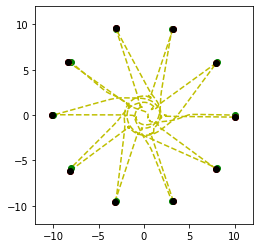

In [1]:
# RMPflow basic classes
# @author Anqi Li
# @date April 8, 2019

from rmp import RMPRoot, RMPNode
from rmp_leaf import CollisionAvoidance, CollisionAvoidanceDecentralized, GoalAttractorUni

import numpy as np
from numpy.linalg import norm

import platform

remote = "iPad" not in platform.platform()


if remote:
	from scipy.integrate import solve_ivp as ode
else:
	from ode import ode_RK as ode

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import math
#from scipy.spatial.distance import pdist

# ---------------------------------------------
# build the rmp tree

####
%matplotlib inline
from IPython.display import HTML

N = 10
theta = np.arange(0, 2 * np.pi, 2 * np.pi / N)
x_g = np.stack((np.cos(theta), np.sin(theta))).T * 10


r = RMPRoot('root')

robots = []


def create_mappings(i):
    phi = lambda y, i=i: np.array([[y[2 * i, 0]], [y[2 * i + 1, 0]]])
    J = lambda y, i=i: np.concatenate((
            np.zeros((2, 2 * i)),
            np.eye(2),
            np.zeros((2, 2 * (N - i - 1)))), axis=1)
    J_dot = lambda y, y_dot: np.zeros((2, 2 * N))

    return phi, J, J_dot


for i in range(N):
    phi, J, J_dot = create_mappings(i)
    robot = RMPNode('robot_' + str(i), r, phi, J, J_dot)
    robots.append(robot)


gas = []

for i in range(N):
    ga = GoalAttractorUni(
        'ga_robot_' + str(i),
        robots[i],
        x_g[i],
        alpha = 1,
        gain = 1,
        eta = 2)

    gas.append(ga)

iacas = []
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        iaca = CollisionAvoidanceDecentralized(
            'ca_robot_' + str(i) + '_robot_' + str(j),
            robots[i],
            robots[j],
            R=1)
        iacas.append(iaca)

# ----------------------------------------------

# -----------------------------------------
# possible initial configurations
x_0 = - x_g + np.random.randn(*x_g.shape) * 0.2

x = x_0.reshape(-1)
x_dot = np.zeros_like(x)

state_0 = np.concatenate((x, x_dot), axis=None)


r.set_root_state(x, x_dot)
r.pushforward()
[leaf.update() for leaf in iacas]
r.pullback()
# --------------------------------------------

# --------------------------------------------
# dynamics
def dynamics(t, state):
    state = state.reshape(2, -1)
    x = state[0]
    x_dot = state[1]
    r.set_root_state(x, x_dot)
    r.pushforward()
    [leaf.update() for leaf in iacas]
    r.pullback()
    x_ddot = r.resolve()
    state_dot = np.concatenate((x_dot, x_ddot), axis=None)
    return state_dot
# --------------------------------------------

# ---------------------------------------------
# solve the diff eq
sol = ode(dynamics, [0, 60], state_0)
# ---------------------------------------------

# --------------------------------------------
# plot trajectories


for i in range(N):
    plt.plot(sol.y[2 * i], sol.y[2 * i + 1], 'y--')
    #plt.plot(sol[:, 2*i], sol[:, 2*i+1], 'y--')
    plt.plot(x_g[i, 0], x_g[i, 1], 'go')
    plt.plot(x_0[i, 0], x_0[i, 1], 'ro')


plt.axis(np.array([-12, 12, -12, 12]))
plt.gca().set_aspect('equal', 'box')

fig = plt.gcf()
ax = plt.gca()

agents, = plt.plot(sol.y[0: 2 * N: 2, 0], sol.y[1: 2 * N + 1: 2, 0], 'ko')


def init():  # only required for blitting to give a clean slate.
    return agents,


def animate(i):
    nsteps = sol.y.shape[-1]
    agents.set_xdata(sol.y[0: 2 * N: 2, i % nsteps])
    agents.set_ydata(sol.y[1: 2 * N + 1: 2, i % nsteps])
    return agents,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True)


####
#plt.show()
# --------------------------------------------


In [2]:
ani._repr_html_() is None

True

In [3]:
ani

In [4]:
from matplotlib import rc
rc('animation', html='html5')

In [5]:
ani

RuntimeError: Requested MovieWriter (ffmpeg) not available